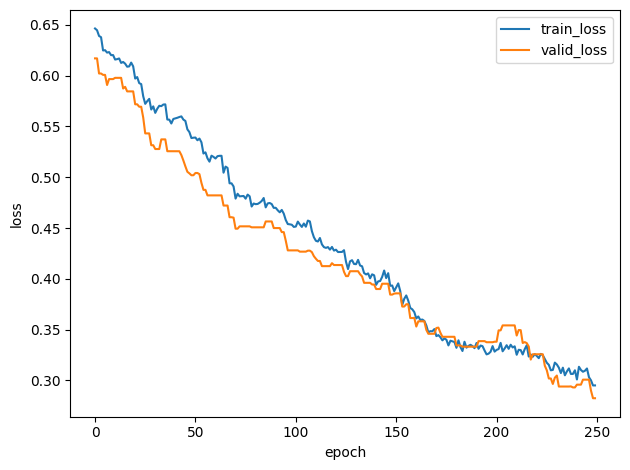

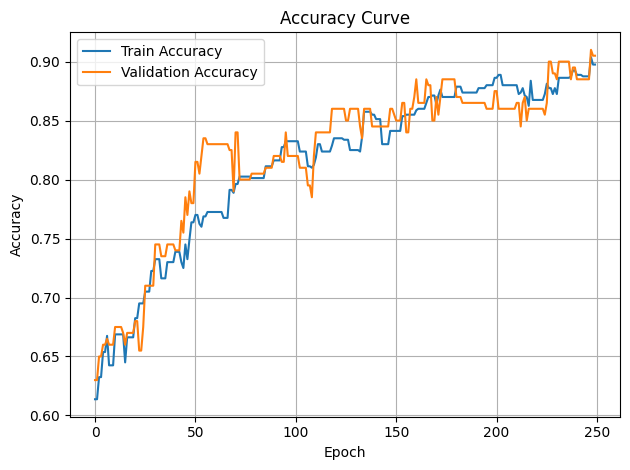

In [3]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pyperch import Trainer
from pyperch.config import TrainConfig, OptimizerConfig
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_accuracy

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Make a simple binary classification dataset
# -------------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed
)
X = X.astype(np.float32)
y = y.astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)

# -------------------------------------------------------------------
# 3. Define a simple MLP classifier
# -------------------------------------------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.net(x)


model = SimpleClassifier()
loss_fn = nn.CrossEntropyLoss()

# -------------------------------------------------------------------
# 4. Configure RHC optimizer + metrics
# -------------------------------------------------------------------
opt_cfg = OptimizerConfig(
    name="rhc",
    step_size=0.05,       # step size for hill climbing
)

cfg = TrainConfig(
    device="cpu",
    seed=seed,
    max_epochs=250,       
    optimizer="rhc",
    optimizer_config=opt_cfg,
    optimizer_mode="per_epoch",   # RHC typically per-epoch
    metrics={
        "train": [Accuracy()],
        "valid": [Accuracy()],
    },
    callbacks=[],          # HistoryCallback is auto-included
)

# -------------------------------------------------------------------
# 5. Train
# -------------------------------------------------------------------
trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

# -------------------------------------------------------------------
# 6. Plot loss curves
# -------------------------------------------------------------------
plot_losses(history)

# -------------------------------------------------------------------
# 7. Plot accuracy curves
# -------------------------------------------------------------------
plot_accuracy(history)


Final train loss: 1752.893817608173
Final valid loss: 2306.3631591796875
Final train R^2: 0.9407165857704259
Final valid R^2: 0.9299652993260061


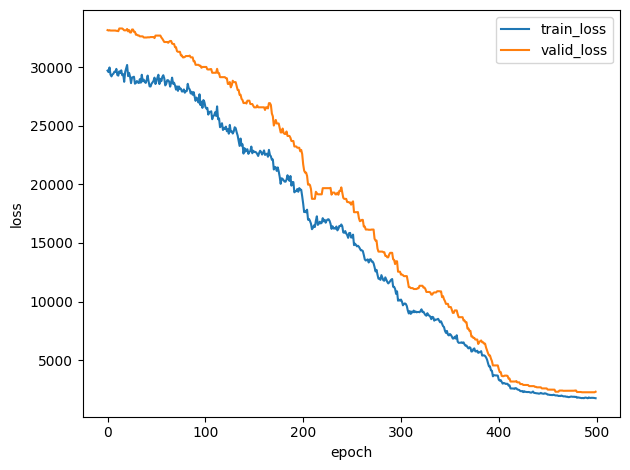

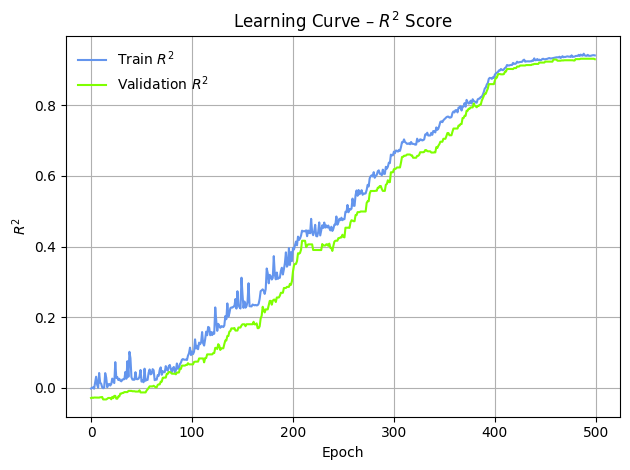

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pyperch import Trainer
from pyperch.config import TrainConfig, OptimizerConfig
from pyperch.core.metrics import MSE, R2
from pyperch.utils import plot_losses

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Regression dataset
# -------------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)  # 2D target

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)

# -------------------------------------------------------------------
# 3. Simple MLP regressor
# -------------------------------------------------------------------
class SimpleRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x)


model = SimpleRegressor()
loss_fn = nn.MSELoss()

# -------------------------------------------------------------------
# 4. RHC optimizer config + metrics (MSE + R²)
# -------------------------------------------------------------------
opt_cfg = OptimizerConfig(
    name="rhc",
    step_size=0.5,
)

cfg = TrainConfig(
    device="cpu",
    seed=seed,
    max_epochs=500,              # tweak as needed
    optimizer="rhc",
    optimizer_config=opt_cfg,
    optimizer_mode="per_epoch", # can try "per_batch" later
    metrics={
        "train": [MSE(), R2()],
        "valid": [MSE(), R2()],
    },
    callbacks=[],
)

# -------------------------------------------------------------------
# 5. Train
# -------------------------------------------------------------------
trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

# -------------------------------------------------------------------
# 6. Plot loss learning curve (train + valid)
# -------------------------------------------------------------------
plot_losses(history)

# -------------------------------------------------------------------
# 7. Plot R² learning curve (train + valid)
# -------------------------------------------------------------------
epochs = history["epoch"]
train_r2 = history["train_metrics"].get("r2", [])
valid_r2 = history["valid_metrics"].get("r2", [])

plt.figure()
if train_r2:
    plt.plot(epochs, train_r2, label="Train $R^2$", color="cornflowerblue")
if valid_r2:
    plt.plot(epochs, valid_r2, label="Validation $R^2$", color="chartreuse")

plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.title(r"Learning Curve – $R^2$ Score")
plt.grid(True)
plt.legend(frameon=False)
plt.tight_layout()

print("Final train loss:", history["train_loss"][-1])
print("Final valid loss:", history["valid_loss"][-1])
if train_r2:
    print("Final train R^2:", train_r2[-1])
if valid_r2:
    print("Final valid R^2:", valid_r2[-1])

Frozen layer unchanged: True


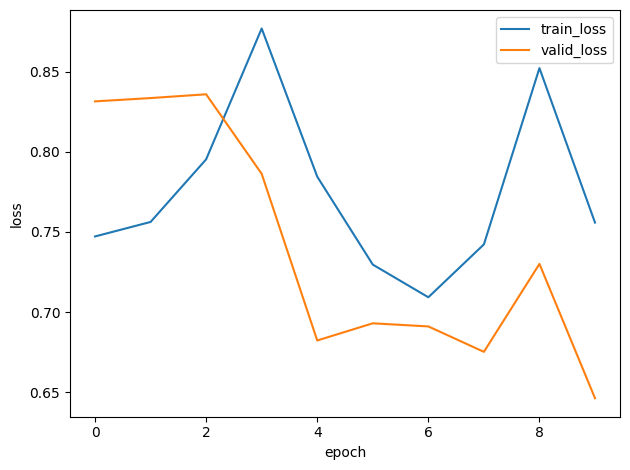

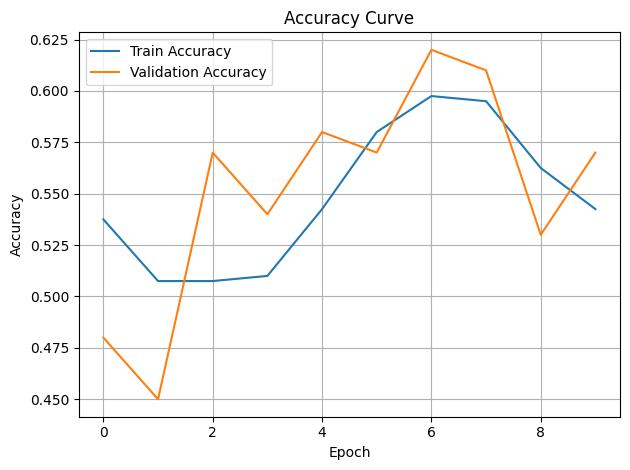

In [3]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from pyperch.config.schema import TrainConfig, OptimizerConfig
from pyperch.core.trainer import Trainer
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_accuracy

# ------------------------------------------------------------
# Dummy Classification Dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Split dataset into train/valid
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)

# ------------------------------------------------------------
# Simple model for testing
# ------------------------------------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 16),   # <-- freeze this
            nn.ReLU(),
            nn.Linear(16, 2),    # <-- meta optimizer on this
        )

    def forward(self, x):
        return self.net(x)

model = SimpleClassifier()

# Capture original weights for freeze verification
original_w0 = model.net[0].weight.detach().clone()

# ------------------------------------------------------------
# TrainConfig for freeze+meta
# ------------------------------------------------------------
cfg = TrainConfig(
    device="cpu",
    max_epochs=10,
    seed=42,
    optimizer="rhc",
    optimizer_mode="per_batch",
    optimizer_config=OptimizerConfig(step_size=0.5),

    # ADD VALID ACCURACY
    metrics={
        "train": [Accuracy()],
        "valid": [Accuracy()],
    },

    layer_modes={
        "net.0.weight": "freeze",
        "net.0.bias": "freeze",
        "net.2.weight": "meta",
        "net.2.bias": "meta",
    }
)

trainer = Trainer(model, nn.CrossEntropyLoss(), cfg)

history = trainer.fit(train_loader, valid_loader)

# ------------------------------------------------------------
# Freeze Verification
# ------------------------------------------------------------
print("Frozen layer unchanged:",
      torch.allclose(original_w0, model.net[0].weight.detach()))

plot_losses(history)
plot_accuracy(history)

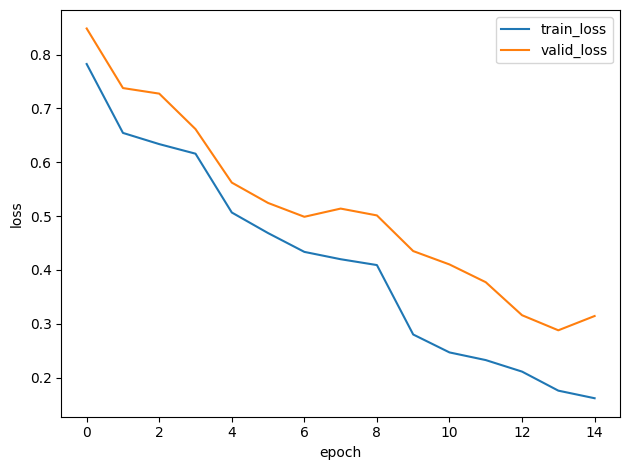

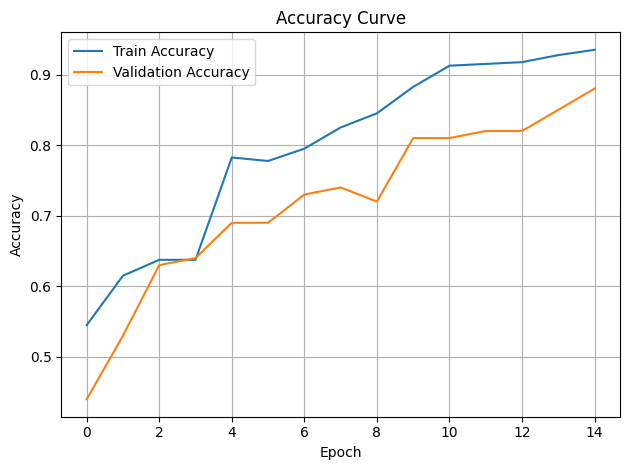

In [4]:
#hybrid test: 

# ------------------------------------------------------------
# Hybrid Layer Modes: grad + meta
# ------------------------------------------------------------

model = SimpleClassifier()

cfg = TrainConfig(
    device="cpu",
    max_epochs=15,
    seed=42,

    optimizer="rhc",  # meta optimizer for layer 2
    optimizer_mode="per_batch",
    optimizer_config=OptimizerConfig(step_size=0.5),

    # ADD VALID ACCURACY
    metrics={
        "train": [Accuracy()],
        "valid": [Accuracy()],
    },

    # Hybrid: Layer 0 = Adam, Layer 2 = RHC
    layer_modes={
        "net.0.weight": "grad",
        "net.0.bias": "grad",
        "net.2.weight": "meta",
        "net.2.bias": "meta",
    }
)

trainer = Trainer(model, nn.CrossEntropyLoss(), cfg)

# include valid_loader here:
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)
plot_accuracy(history)

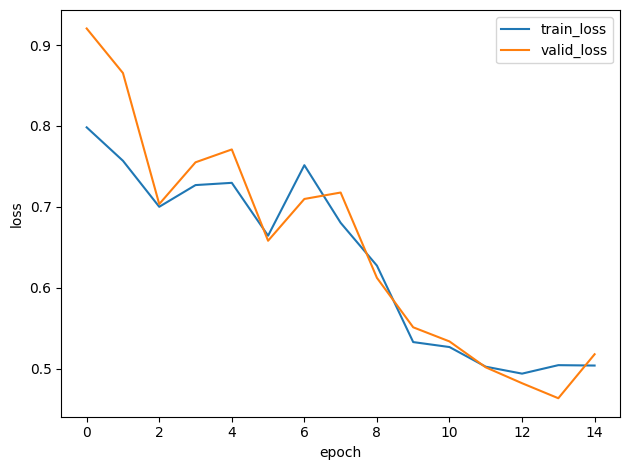

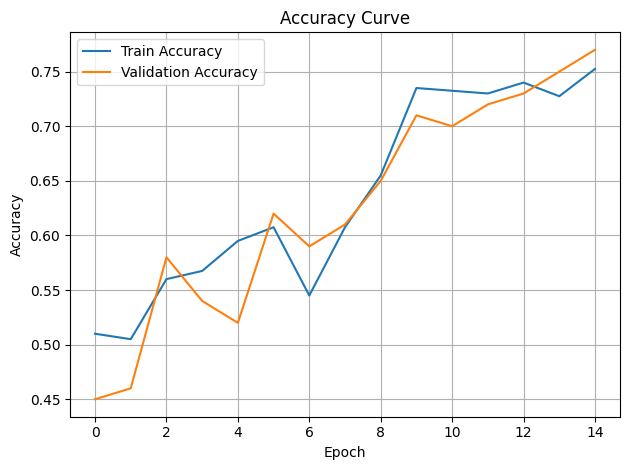

In [5]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with RHC
# ------------------------------------------------------------

model = SimpleClassifier()

cfg = TrainConfig(
    device="cpu",
    max_epochs=15,
    seed=42,

    optimizer="rhc",                 # Meta optimizer for output layer
    optimizer_mode="per_batch",
    optimizer_config=OptimizerConfig(step_size=0.5),

    # ADD VALID ACCURACY
    metrics={
        "train": [Accuracy()],
        "valid": [Accuracy()],
    },

    layer_modes={
        "net.0.weight": "freeze",    # First layer frozen
        "net.0.bias": "freeze",

        # NOTE: Middle layer defaults to "meta" unless explicitly set.
        # If you want middle layer to be Adam, set "grad" here.

        "net.2.weight": "meta",      # Output layer trained by RHC
        "net.2.bias":  "meta",
    }
)

trainer = Trainer(model, nn.CrossEntropyLoss(), cfg)

# IMPORTANT: include valid_loader so validation curves appear
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)
plot_accuracy(history)
